# Load Packages

In [23]:
from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict

import torch, torchvision
from torch import nn, optim #Torch NN(Conv, Pooling, etc.), Optimization.
from torch.optim import lr_scheduler #Optimization LR Scheduler.
import torch.nn.functional as F #NN Functional.
import torchvision.transforms as T #Torchvision Transforms.
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models #Torchvistion Models.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Train Folders

**We will get each label folder and we can see that we have 6 folders**

* buildings = 0 
* forest = 1
* glacier = 2
* mountain = 3
* sea = 4
* street = 5 

In [24]:
train_folders = sorted(glob('../input/intel-image-classification/seg_train/seg_train/*'))
len(train_folders)

6

# Load & View Images

**Here we build 3 helpers to load and view images**

In [25]:
def load_image(img_path, resize=True):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    
    if resize:
        img = cv2.resize(img, (64,64), interpolation = cv2.INTER_AREA)
    
    return img

# Train set images class distribution.

* buildings = 0 
* forest = 1
* glacier = 2
* mountain = 3
* sea = 4
* street = 5 

In [26]:
#Class Classification.
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

class_indices = [0, 1, 2, 3, 4, 5]

**We will copy all the images to new dir, the purpose is to make it easier to torchvision dataset helpers to utilize the images**

In [27]:
#Train & Valid Directory.
!rm -rf data

DATA_DIR = Path('data')

DATASETS = ['train', 'val']

for ds in DATASETS:
    for cls in class_names:
        (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

**We are going to reserve 80% for train and 20% for validation for each class, then copy them to the correct folder**

In [28]:
#Class Distribution & Split.
for i, cls_index in enumerate(class_indices):
    image_paths = np.array(glob(f'{train_folders[cls_index]}/*jpg')) 
    class_name = class_names[i] 
    print(f'{class_name}: {len(image_paths)}') 
    np.random.shuffle(image_paths)
    
    ds_split = np.split(
        image_paths,
        indices_or_sections = [int(.8 * len(image_paths)), int(.9 * len(image_paths))]
    )
    
    dataset_data = zip(DATASETS, ds_split)
    for ds, images in dataset_data:
        for img_path in images:
            shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

buildings: 2191
forest: 2271
glacier: 2404
mountain: 2512
sea: 2274
street: 2382


# Requirement of ResNet

In [37]:
#Transforms.
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'train': T.Compose([
    T.RandomResizedCrop(size = 256),
    T.RandomRotation(degrees = 15),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean_nums, std_nums)]),
    'val': T.Compose([
    T.Resize(size = 256),
    T.CenterCrop(size = 224),
    T.ToTensor(),
    T.Normalize(mean_nums, std_nums)]),
}

**Now we will create pytorch dataset for image dataset and dataloaders**

In [42]:
#Image Datasets.
image_datasets = {
    d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

#Data Loaders.
data_loaders = {
    d: DataLoader(image_datasets[d], batch_size=4, shuffle=True, num_workers=4) for d in DATASETS
}

**We will store each class total images for later use**

In [43]:
#Dataset Sizes.
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes

dataset_sizes

{'train': 11224, 'val': 1402}

> # Using pretrained model to classify the images

We will use the pre-trained ResNet to classify this images
1. We will import the model (import all weights and arch except we will change the output layer as number of output class is different from ResNet dataset)
2. Convert it into training mode
3. Train the model on new data
4. Evaluate
5. Hopefully celebrate :)

In [75]:
base_model = create_model(len(class_names))

In [68]:
class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      # First 2D convolutional layer, taking in 1 input channel (image),
      # outputting 32 convolutional features, with a square kernel size of 3
      self.conv1 = nn.Conv2d(3, 64, 7, 2,3, bias=False)
      # Second 2D convolutional layer, taking in the 32 input layers,
      # outputting 64 convolutional features, with a square kernel size of 3
      self.conv2 = nn.Conv2d(64, 128, 3, 1)

      # Designed to ensure that adjacent pixels are either all 0s or all active
      # with an input probability
      self.dropout1 = nn.Dropout2d(0.25)
      self.dropout2 = nn.Dropout2d(0.5)

      # First fully connected layer
      self.fc1 = nn.Linear(9216, 128)
      # Second fully connected layer that outputs our 10 labels
      self.fc2 = nn.Linear(128, 6)

f_model = Net()
print(base_model)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)


In [74]:
#Create Model
def create_model(n_classes):
    #resnet34, resnet152, wide_resnet101_2, resnext101_32x8d
    model = models.resnext101_32x8d(pretrained = True) 
    
    n_features = model.fc.in_features
    
    model.fc = nn.Linear(n_features, n_classes)
    
    return model.to(device)

In [76]:
#Print Model Layer.
base_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [58]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train() #Convert to train mode
    losses = []
    correct_predictions = 0
    
    for inputs, labels in data_loader:
        inputs = inputs.to(device) #Push array to gpu
        labels = labels.to(device)
        
        outputs = model(inputs) #get prob of output per class
        
        _, preds = torch.max(outputs, dim=1) # get max of pred
        loss = loss_fn(outputs, labels) # get loss
        
        correct_predictions += torch.sum(preds==labels)
        losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    scheduler.step()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval() #Evaluation mode
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            
            _, preds = torch.max(outputs, dim=1)
            
            loss = loss_fn(outputs, labels)
            
            correct_predictions += torch.sum(preds==labels)
            losses.append(loss.item())
    
    return correct_predictions.double() / n_examples, np.mean(losses) 

**Evaluation is simple, we don't even do gradient calculations**

In [59]:
def train_model(model, data_loaders, dataset_sizes, device, n_epochs=5):
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    loss_fn = nn.CrossEntropyLoss().to(device)
    
    history = defaultdict(list)
    best_accuracy = 0
    
    for epoch in range(n_epochs):
        print(f'Epoch {epoch + 1}/{n_epochs}')
        print('-' * 10)
        
        train_acc, train_loss = train_epoch(model, data_loaders['train'], loss_fn, 
                                            optimizer, device, scheduler, dataset_sizes['train'])
        
        print(f'Train loss {train_loss} accuracy {train_acc}')
        
        val_acc, val_loss = eval_model(model, data_loaders['val'], loss_fn, device, dataset_sizes['val'])
        
        print(f'Val loss {val_loss} accuracy {val_acc}')
        print()
        
        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)
        
        if val_acc > best_accuracy:
            torch.save(model.state_dict(), 'best_model_state.bin')
            best_accuracy = val_acc
            
    print(f'Best val accuracy: {best_accuracy}')
    
    model.load_state_dict(torch.load('best_model_state.bin'))
    
    return model, history

In [77]:
%%time

base_model, history = train_model(base_model, data_loaders, dataset_sizes, device, n_epochs=5)

Epoch 1/5
----------
Train loss 0.6903620961488802 accuracy 0.7468816821097648
Val loss 0.2682502674060924 accuracy 0.9079885877318117

Epoch 2/5
----------
Train loss 0.4729875814983142 accuracy 0.8251069137562367
Val loss 0.3030985652088842 accuracy 0.8980028530670471

Epoch 3/5
----------
Train loss 0.4134169215457919 accuracy 0.8510334996436208
Val loss 0.29479839820807807 accuracy 0.9022824536376605

Epoch 4/5
----------
Train loss 0.38345630585452634 accuracy 0.861368496079829
Val loss 0.25750778739205366 accuracy 0.9165477888730386

Epoch 5/5
----------
Train loss 0.34831026307734014 accuracy 0.8748218104062723
Val loss 0.2652227729279813 accuracy 0.9144079885877319

Best val accuracy: 0.9165477888730386
CPU times: user 47min 46s, sys: 11min 23s, total: 59min 9s
Wall time: 1h 25s


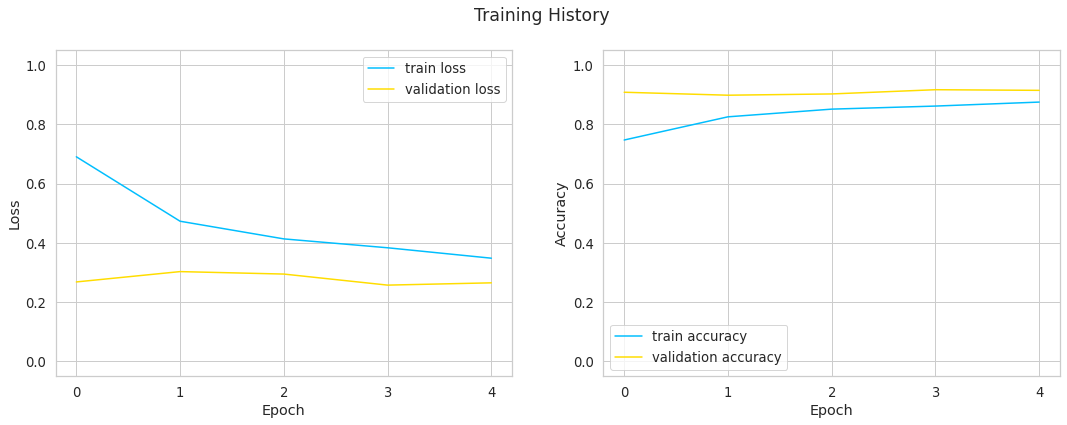

In [78]:
#Visualize Training History.
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    ax1.plot(history['train_loss'], label='train loss')
    ax1.plot(history['val_loss'], label='validation loss')
    
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend()
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    
    ax2.plot(history['train_acc'], label='train accuracy')
    ax2.plot(history['val_acc'], label='validation accuracy')
    
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_ylim([-0.05, 1.05])
    ax2.legend()
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    
    fig.suptitle('Training History')
    
plot_training_history(history)